In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,PolynomialFeatures,StandardScaler,RobustScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,f1_score, \
    r2_score, mean_absolute_error, mean_squared_error, classification_report,median_absolute_error
from sklearn.model_selection import train_test_split,cross_val_score
import statsmodels.api as sm
import copy
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

# Первоначальная предобработка данных(квартиры на продажу в Москве и Санкт-Петербурге)

In [3]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQxxmZm6YG54VucQ9yRgWFQXtOI-RFJ5-sOLT93LpaYGYc-vabL9LOzzkRXX-LmSROTA7hOL1C327nZ/pub?gid=213261502&single=true&output=csv')
data['flat_id'] = data['link'].str.extract('(\d+)')

data.drop('link', axis = 1,inplace = True)

data.drop(['accommodation_type','deal_type'],axis = 1,inplace = True)

data.drop('phone', axis =1, inplace=True)

data_duplicated_indexes = data[data.duplicated() == True].index

data = data.drop(data_duplicated_indexes, axis =0)

data[['total_meters', 
      'price_per_m2',
      'year_of_construction',
      'living_meters',
      'kitchen_meters']] = data[['total_meters', 'price_per_m2','year_of_construction','living_meters','kitchen_meters']].replace(-1.0, None)

data[['total_meters', 
      'price_per_m2',
      'year_of_construction',
      'living_meters',
      'kitchen_meters']].dtypes

total_meters            object
price_per_m2             int64
year_of_construction    object
living_meters           object
kitchen_meters          object
dtype: object

In [4]:
data.isna().sum()

author                    91
author_type               80
city                       0
floor                      0
floors_count               0
rooms_count                0
total_meters               9
price_per_m2               0
price                      0
year_of_construction     719
living_meters           3278
kitchen_meters          3508
district                 764
street                  1527
underground              643
residential_complex     5898
flat_id                    0
dtype: int64

In [5]:
data.drop(data[(data.isna().sum(axis=1) >= 4)].index, axis = 0, inplace =True)

data.loc[(data.price_per_m2 <=0),'price_per_m2'] = None 

data.isna().sum()

data['author'].fillna(data['author'].mode()[0], inplace =True)
data['author_type'].fillna(data['author_type'].mode()[0], inplace =True)

data[['total_meters',
             'living_meters',
             'kitchen_meters']] = data[['total_meters','living_meters','kitchen_meters']].astype('float64')

data['total_meters'].fillna(data['total_meters'].median(), inplace =True)
data['price_per_m2'].fillna(data['price_per_m2'].median(), inplace =True)

data['year_of_construction'] = data['year_of_construction'].astype('int64',errors='ignore')

data.isna().sum()

data = data.drop(data[data['year_of_construction'].isna()].index, axis = 0)

data = data.drop(data[data['living_meters'] < 0].index, axis = 0)

In [6]:
# проверял содержат ли переменные символы, отличные букв
#data[data.underground.str.contains(r'[^\D]',regex =True, na=False)] 
data = data.drop(data.loc[data['author'].str.contains('ID',na = False), 'author'].index)

## living_meters (исследование признака и заполнение пропусков)

## Условия для линейной регрессии
1. Количественные переменные
2. линейная связь между зависимой и независимыми переменными(есть)
3. нормальное распределение ошибок
4. Гомоскедастичность(остатки имеют плюс-минус равную дисперсию во всех значениях х)
5. Отсутствует мультиколлинеарность(независимые переменные:,'total_meters','kitchen_meters','price'), почти отсутсвует

## Полиномиальная регрессия - оказалась лучше множественной линейной регрессии(лучший набор признаков : 1,3,4)

In [7]:
# создаю датасет для регрессии
data_reg = data[['living_meters','total_meters','price','kitchen_meters','rooms_count']].copy()

mae: 9.844 
mse: 284.843 
rmse: 16.877 
r2:0.813
1.9768226645875424
CV R^2: 0.787 +- 0.057


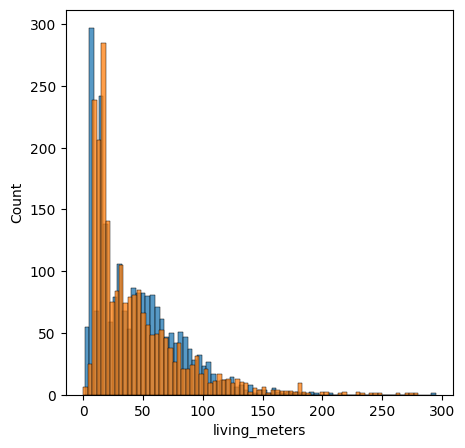

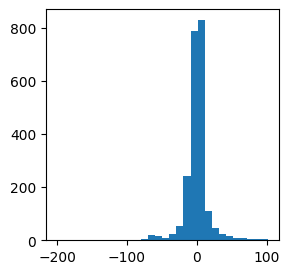

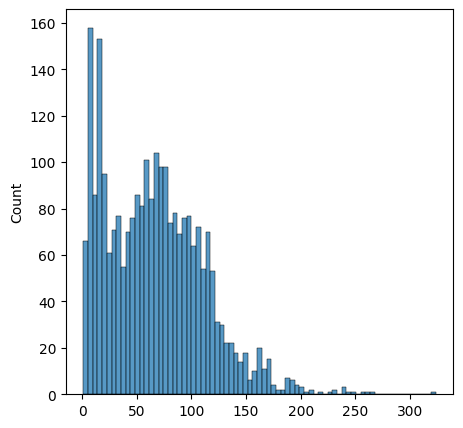

In [8]:
y_living_meters = data_reg[(data_reg['living_meters'].notnull())]['living_meters']
X_living_meters = data_reg[(data_reg['living_meters'].notnull())].iloc[:,[1,2,4]]

X_train, X_test, y_train, y_test = train_test_split(X_living_meters, y_living_meters, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=1)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
lr = LinearRegression(fit_intercept=True)

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
resid = y_test - y_pred

mae = mean_absolute_error(y_test, y_pred) 
# rmse насколько в среднем по модулю отличаются предсказанные от истинных в оригинальных единицах измерения
mse = mean_squared_error(y_test, y_pred) # mse и rmse сильнее подвержены влиянию выбросов, чем mae
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

plt.figure(figsize=(5, 5))
sns.histplot(y_pred,bins = 75)
sns.histplot(y_test,bins = 75);

print(sm.stats.stattools.durbin_watson(resid))

# распределение ошибок
plt.figure(figsize= (3,3))
plt.hist(resid,bins = 30);

scores = cross_val_score(lr, X_test, y_test, cv=5)
print('CV R^2: {:.3f} +- {:.3f}'.format(np.mean(scores), np.std(scores)))

living_meters_nan = data[data.living_meters.isna()][['total_meters','price','rooms_count']]
living_meters_nan = poly.fit_transform(living_meters_nan)
living_meters_nan = lr.predict(living_meters_nan)

plt.figure(figsize=(5, 5))
sns.histplot(living_meters_nan,bins = 75);

data.loc[data.living_meters.isna(),'living_meters'] = living_meters_nan

# Удаляю все наблюдения, которые не удалось заполнить

In [9]:
data.shape

(13628, 17)

In [10]:
data.isna().sum()

author                     0
author_type                0
city                       0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction       0
living_meters              0
kitchen_meters          2769
district                 531
street                  1265
underground              476
residential_complex     4660
flat_id                    0
dtype: int64

In [11]:
data.drop(data[data.street.isna()].index, inplace = True)
data.drop(data[data.kitchen_meters.isna()].index, inplace = True)
data.drop(data[data.underground.isna()].index, inplace = True)
data.drop(['residential_complex'] , axis = 1, inplace = True)

In [12]:
data.shape

(9387, 16)

In [13]:
data.isna().sum()

author                  0
author_type             0
city                    0
floor                   0
floors_count            0
rooms_count             0
total_meters            0
price_per_m2            0
price                   0
year_of_construction    0
living_meters           0
kitchen_meters          0
district                0
street                  0
underground             0
flat_id                 0
dtype: int64

# Основной алгоритм

In [28]:
data['year_of_construction'] = data.year_of_construction.astype('int32')

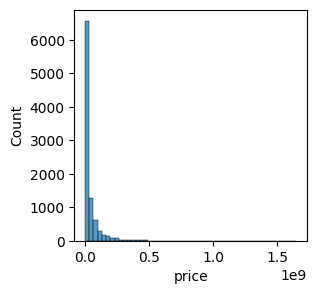

In [14]:
plt.figure(figsize = (3,3))
sns.histplot(data=data['price'],bins =50);

In [196]:
y = data['price'].copy()
X = data.loc[:,['city','floors_count', 'rooms_count',
                'total_meters', 'year_of_construction','living_meters', 'kitchen_meters', 
                'district', 'underground']].copy() # удалю author,floor,street

dict_classes = {}
for item in X.select_dtypes(['object']):
    label_encoder = LabelEncoder()
    label_encoder = copy.copy(label_encoder.fit(X[item]))
    dict_classes[item] = label_encoder
    X[item] = label_encoder.transform(X[item])

# Удаление выбросов в y
iqr = stats.iqr(y) # разница между 3 и 1 квартилями
q3 = np.quantile(y, 0.75)
upper = q3 #- np.quantile(y, 0.1)#+ iqr #* 1.5 
outliers = y[(y > upper)]
# потом на реальных данных можо выкидывать те значения Х, которые являются выбросами в тренировочном наборе и выводить алерт,
# что мол вы ввели аномально большие значения. Пороговые значения для вывода алерта нужно будет потом определить как-нибудь
outliers_stats = X.loc[outliers.index].describe()

y.drop(outliers.index, inplace = True)
X = X.loc[y.index]

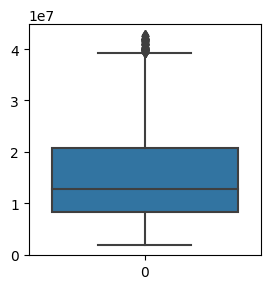

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize = (3,3))
sns.boxplot(y.values);

In [198]:
y.shape

(7040,)

In [206]:
#{'criterion': 'poisson', 'max_depth': 5, 'max_features': 1.0, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.004227138227420037, 'splitter': 'best'
# criterion='absolute_error', 
#                             max_depth= 9, 
#                             max_features=1.0, 
#                             min_samples_split=7, 
#                             splitter='best', 
#                             min_weight_fraction_leaf=0.004227138227420037, 
#                             min_impurity_decrease =0.02
DTR = DecisionTreeRegressor(random_state=42,
                            criterion='absolute_error', 
                            max_depth= 10, 
                            max_features=1.0, 
                            min_samples_split=7, 
                            splitter='random', 
                            min_weight_fraction_leaf=0.00423, 
                            min_impurity_decrease =0.02)

ABC = AdaBoostRegressor(random_state=42,
                        estimator = DTR, 
                        n_estimators=125, 
                        learning_rate=0.01, 
                       loss='linear',
                       )
ABC.fit(X_train, y_train)
y_pred = ABC.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # показывает дисперсию ошибки
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f \nmedae:%.3f'%(mae,mse,rmse,r2,medae))

mae: 2888003.877 
mse: 19160256195682.941 
rmse: 4377242.990 
r2:0.798 
medae:1700000.000


In [204]:
input_data = np.array(['Sankt-Peterburg',19,2,60.1,2020,27.1,14.4,'Vasileostrovskij','Zenit'])
input_data = pd.Series(input_data, index =X.columns)
for key in dict_classes.keys():
    input_data[key] = dict_classes[key].transform(np.array([input_data[key]])).item()
input_data = input_data.values.reshape(1,-1)
np.round(ABC.predict(input_data).item()) # 12578976.0

11946040.0

In [205]:
np.set_printoptions(suppress=True)
ABC.feature_importances_

array([0.10760095, 0.03798481, 0.19382423, 0.3362972 , 0.05169517,
       0.13083982, 0.10636796, 0.02024183, 0.01514803])

In [34]:
outliers_stats

,author,city,floor,floors_count,rooms_count,total_meters,year_of_construction,living_meters,kitchen_meters,district,street,underground
count,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000
mean,242.335871,0.132255,9.143673,14.572788,4.225975,203.445014,1999.009515,116.890970,24.411513,65.338725,812.505233,154.392959
std,245.761352,0.338929,10.875630,15.060108,0.873734,74.382333,38.882582,47.035995,15.479984,41.122366,452.616744,92.879157
min,6.000000,0.000000,1.000000,2.000000,0.500000,68.200000,1798.000000,13.000000,3.000000,0.000000,1.000000,0.000000
25%,110.000000,0.000000,3.000000,6.000000,4.000000,158.000000,2004.000000,87.169919,15.000000,30.000000,399.000000,86.000000
50%,148.000000,0.000000,5.000000,9.000000,4.000000,195.070000,2012.000000,111.000000,20.000000,68.000000,809.000000,139.000000
75%,232.000000,0.000000,10.000000,15.000000,5.000000,235.000000,2020.500000,138.703855,28.900000,96.000000,1212.000000,246.500000
max,1043.000000,1.000000,79.000000,97.000000,5.000000,659.400000,2025.000000,450.000000,116.000000,135.000000,1571.000000,319.000000


## Теперь тренирую на всех данных

In [172]:
y = data['price'].copy()
X = data.loc[:,['author', 'city', 'floor', 'floors_count', 'rooms_count',
                'total_meters', 'year_of_construction','living_meters', 'kitchen_meters', 
                'district', 'street', 'underground']].copy() 

dict_classes = {}
for item in X.select_dtypes(['object']):
    label_encoder = LabelEncoder()
    label_encoder = copy.copy(label_encoder.fit(X[item]))
    dict_classes[item] = label_encoder
    X[item] = label_encoder.transform(X[item])
    
iqr = stats.iqr(y) # (межквартильный размах)
q3 = np.quantile(y, 0.75)
upper = q3 #+ iqr *1.5
outliers = y[(y > upper)]
# потом на реальных данных можо выкидывать те значения Х, которые являются выбросами в тренировочном наборе и выводить алерт,
# что мол вы ввели аномально большие значения. Пороговые значения для вывода алерта нужно будет потом определить как-нибудь
outliers_stats = X.loc[outliers.index].describe()

y.drop(outliers.index, inplace = True)
X = X.loc[y.index]

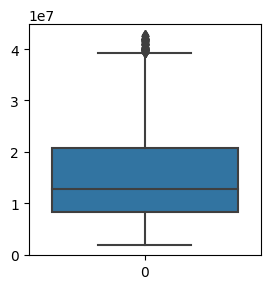

In [173]:
plt.figure(figsize = (3,3))
sns.boxplot(y.values);

In [174]:
y.shape

(7040,)

In [180]:
DTR = DecisionTreeRegressor(random_state=42,
                            criterion='absolute_error', 
                            max_depth= 9, 
                            max_features=1.0, 
                            min_samples_split=7, 
                            splitter='random', 
                            min_weight_fraction_leaf=0.004227138227420037, 
                            min_impurity_decrease =0.02)

ABR = AdaBoostRegressor(random_state=42,
                        estimator = DTR, 
                        n_estimators=125, 
                        learning_rate=0.01, 
                       loss='linear',
                       )
ABR.fit(X, y)

AdaBoostRegressor(estimator=DecisionTreeRegressor(criterion='absolute_error',
                                                  max_depth=9, max_features=1.0,
                                                  min_impurity_decrease=0.02,
                                                  min_samples_split=7,
                                                  min_weight_fraction_leaf=0.004227138227420037,
                                                  random_state=42,
                                                  splitter='random'),
                  learning_rate=0.01, n_estimators=125, random_state=42)

In [181]:
np.set_printoptions(suppress=True)
ABR.feature_importances_

array([0.03738397, 0.10727566, 0.00461717, 0.02649873, 0.20057224,
       0.34181533, 0.04064873, 0.10883402, 0.09949419, 0.01420053,
       0.01006864, 0.00859078])

In [182]:
scores = cross_val_score(ABR, X, y, cv=5)
print('CV R^2: {:.3f} +- {:.3f}'.format(np.mean(scores), np.std(scores)))

CV R^2: 0.558 +- 0.076


In [184]:
input_data = np.array(['GloraX','Sankt-Peterburg',6,19,2,60.1,2020,27.1,14.4,'Vasileostrovskij','Morskoj','Zenit'])
input_data = pd.Series(input_data, index =X.columns)
for key in dict_classes.keys():
    input_data[key] = dict_classes[key].transform(np.array([input_data[key]])).item()
input_data = input_data.values.reshape(1,-1)
np.round(ABR.predict(input_data).item())

12502220.0

In [ ]:
joblib.dump(ABC,'AdaBoostRegressor.joblib')

In [187]:
joblib.dump(dict_classes,'label_encoders.joblib')

['label_encoders.joblib']

In [193]:
data.loc[y.index, ['author', 'city','district', 'street', 'underground']].to_csv('data_for_dash.csv', sep = ';',index= False)